In [1]:
import os
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score



In [2]:
class ImageTextDataset(Dataset):
    def __init__(self, root_folder, transform):
        self.transform = transform
        self.img_paths = []
        self.labels = []
        # Walk through subfolders
        for label_name in os.listdir(root_folder):
            label_path = os.path.join(root_folder, label_name)
            if os.path.isdir(label_path):
                for img_file in os.listdir(label_path):
                    self.img_paths.append(os.path.join(label_path, img_file))
                    self.labels.append(label_name)  # folder name as label

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx]).convert("RGB")
        image = self.transform(image)
        label = self.labels[idx]
        return image, label, os.path.basename(self.img_paths[idx])


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:22<00:00, 15.5MiB/s]


In [4]:
def fine_tune_clip(train_loader, model, epochs=3, lr=1e-5):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        for images, labels, _ in train_loader:
            images = images.to(device)

            # Prepare text tokens for labels
            texts = clip.tokenize(labels).to(device)
            
            # Forward pass
            image_features = model.encode_image(images)
            text_features = model.encode_text(texts)
            
            # Normalize embeddings
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            torch.autograd.set_detect_anomaly(True)

            
            # Compute logits: image-text similarity
            logits_per_image = image_features @ text_features.t()
            logits_per_text = text_features @ image_features.t()
            
            # Labels are diagonal (correct pairs)
            ground_truth = torch.arange(len(images), device=device)

            # Compute contrastive loss (sum of two cross-entropy losses)
            loss = (loss_fn(logits_per_image, ground_truth) + loss_fn(logits_per_text, ground_truth)) / 2

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs} Loss: {loss.item():.4f}")


In [5]:
def encode_images(image_folder, model, preprocess):
    image_paths = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder)])
    images = [preprocess(Image.open(p).convert("RGB")) for p in image_paths]
    images = torch.stack(images).to(device)

    with torch.no_grad():
        features = model.encode_image(images)
        features /= features.norm(dim=-1, keepdim=True)
    return features, image_paths


In [6]:
def retrieve(query_features, gallery_features, gallery_paths, top_k=5):
    similarities = query_features @ gallery_features.T  # cosine similarity matrix
    topk_values, topk_indices = similarities.topk(top_k, dim=-1)

    results = []
    for i in range(query_features.shape[0]):
        retrieved = [gallery_paths[idx] for idx in topk_indices[i].cpu().numpy()]
        results.append(retrieved)
    return results


In [7]:
def visualize_retrieval(query_paths, retrieval_results):
    for i, query_path in enumerate(query_paths):
        plt.figure(figsize=(15, 5))
        
        # Show query
        plt.subplot(1, 6, 1)
        plt.title("Query")
        plt.axis("off")
        plt.imshow(Image.open(query_path))
        
        # Show retrieved images
        for j, img_path in enumerate(retrieval_results[i]):
            plt.subplot(1, 6, j+2)
            plt.title(f"Rank {j+1}")
            plt.axis("off")
            plt.imshow(Image.open(img_path))
        plt.show()


In [8]:
def compute_accuracy(query_labels, retrieval_results, gallery_labels):
    correct = 0
    for i, retrieved_imgs in enumerate(retrieval_results):
        # Check if any retrieved image has the same label as query
        query_label = query_labels[i]
        retrieved_labels = [gallery_labels[os.path.basename(p)] for p in retrieved_imgs]
        if query_label in retrieved_labels:
            correct += 1
    return correct / len(query_labels)


Epoch 1/3 Loss: 1.3863
Epoch 2/3 Loss: 0.7909
Epoch 3/3 Loss: 0.7728


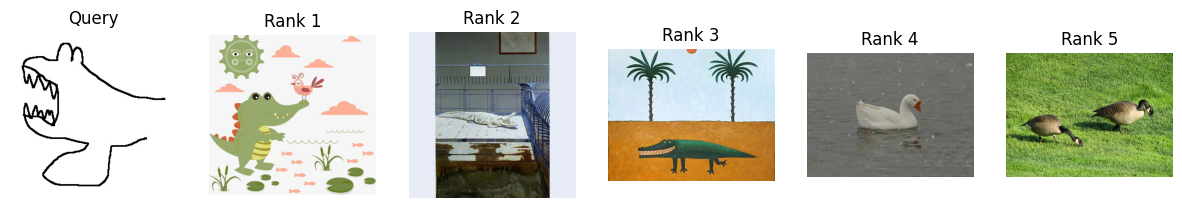

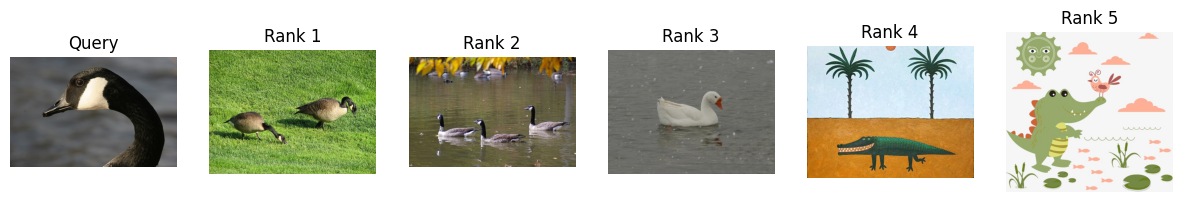

In [ ]:
transform = preprocess
train_dataset = ImageTextDataset("data/training", transform=preprocess)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


fine_tune_clip(train_loader, model)  # Fine-tune model on training set

gallery_features, gallery_paths = encode_images("data/test/gallery", model, preprocess)
query_features, query_paths = encode_images("data/test/query", model, preprocess)

retrieval_results = retrieve(query_features, gallery_features, gallery_paths, top_k=5)
visualize_retrieval(query_paths, retrieval_results)

# BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__file__))) 
# DATA_DIR = os.path.join(BASE_DIR, "data")

# gallery_dir = os.path.join(DATA_DIR, "test/gallery")
# query_dir = os.path.join(DATA_DIR, "test/query")

# gallery_features, gallery_paths = encode_images(gallery_dir, model, preprocess)
# query_features, query_paths = encode_images(query_dir, model, preprocess)